In [ ]:
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import random

In [ ]:
# ────────────────────────── Paths ──────────────────────────
IMG_DIR  = Path("data/Experiment_6/exp6_cam0/exp6_cam0_cropped_small_14d")
MASK_DIR = Path("masks/cam0")
MASK_DIR.mkdir(parents=True, exist_ok=True)

In [ ]:
# ───────────────────────── Baseline ────────────────────────
img_paths = sorted(IMG_DIR.glob("cam0_*.jpg"))
if len(img_paths) < 2:
    raise RuntimeError("Need at least a baseline + one follow-up image")

baseline_bgr = cv2.imread(str(img_paths[0]))
if baseline_bgr is None:
    raise FileNotFoundError(f"Could not load {img_paths[0]}")

baseline_L = cv2.cvtColor(baseline_bgr, cv2.COLOR_BGR2LAB)[:, :, 0]

# ──────────────────────── Helper Function ───────────────────────
def scoby_mask(frame_bgr):
    """
    Returns (diff, mask) where:
      - diff is absdiff in L channel vs. baseline
      - mask is thresholded+cleaned binary SCOBY mask
    """
    L = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2LAB)[:, :, 0]
    diff = cv2.absdiff(L, baseline_L)
    _, mask = cv2.threshold(diff, 0, 255,
                            cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    mask = cv2.medianBlur(mask, 5)
    kernel = np.ones((7, 7), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    return diff, mask

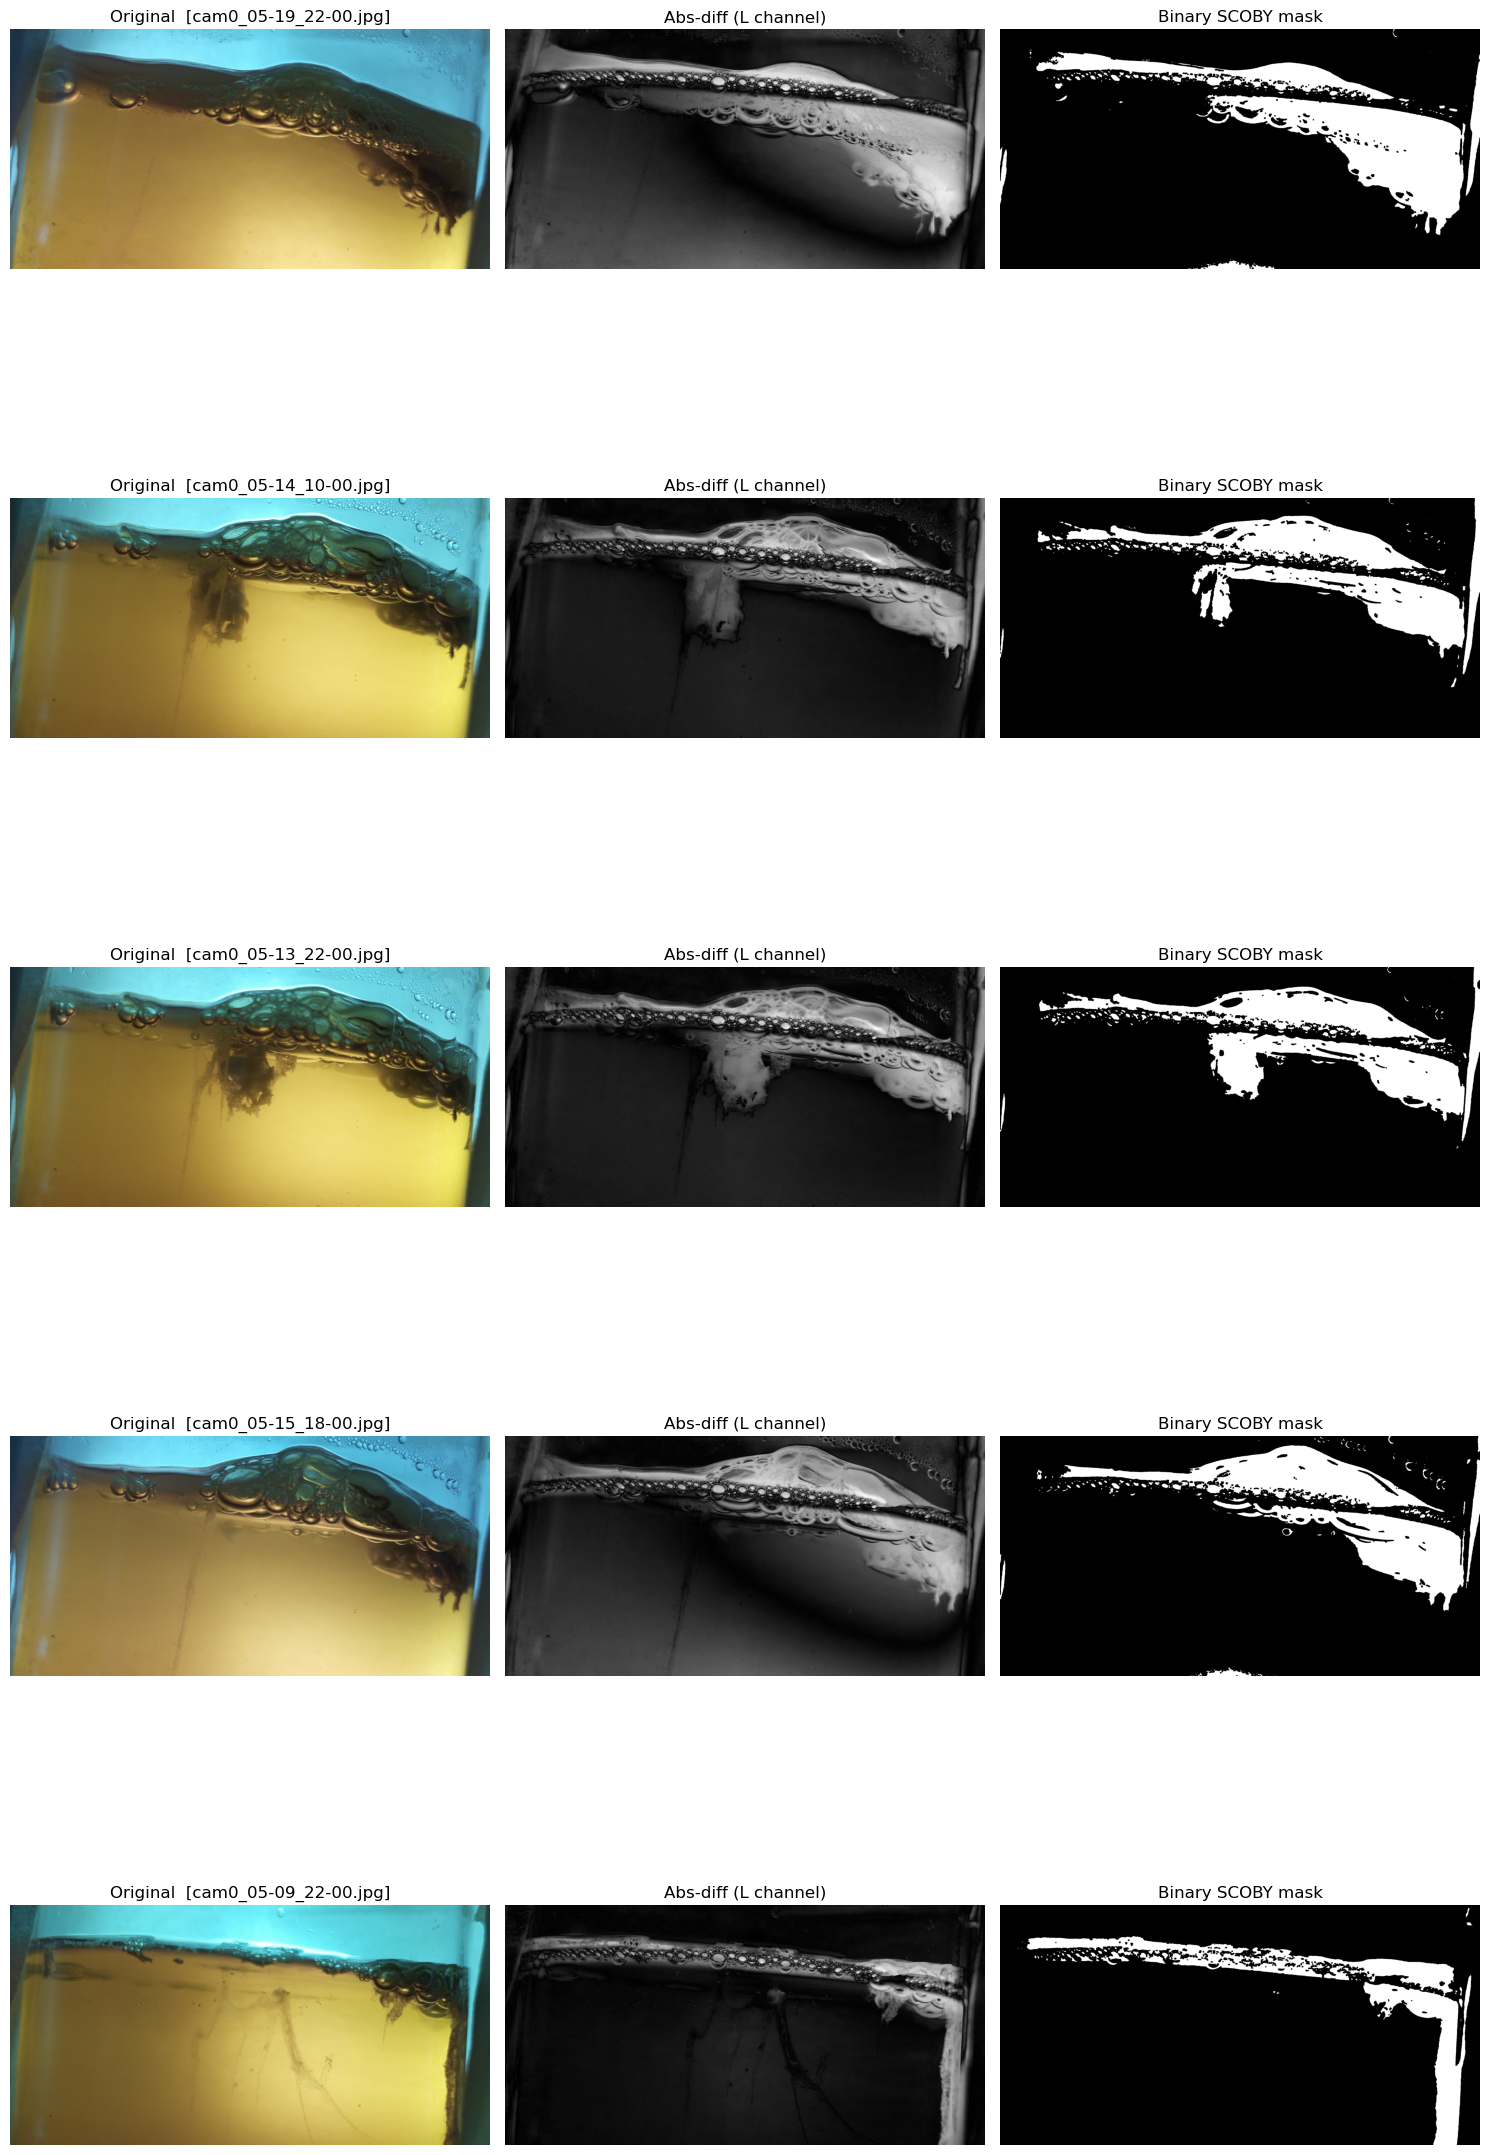

In [2]:
# ────────────────────────── Cell 2 ──────────────────────────
# Randomly sample 5 frames and display Original / Diff / Mask

# pick 5 random follow-up frames
test_paths = random.sample(img_paths[1:], k=min(5, len(img_paths)-1))

n = len(test_paths)
fig, axes = plt.subplots(n, 3, figsize=(15, 5*n))

if n == 1:
    axes = np.expand_dims(axes, 0)

for i, p in enumerate(test_paths):
    bgr = cv2.imread(str(p))
    diff, mask = scoby_mask(bgr)

    ax = axes[i]
    ax[0].imshow(cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB))
    ax[0].set_title(f"Original  [{p.name}]")
    ax[0].axis('off')

    ax[1].imshow(diff, cmap='gray')
    ax[1].set_title("Abs-diff (L channel)")
    ax[1].axis('off')

    ax[2].imshow(mask, cmap='gray')
    ax[2].set_title("Binary SCOBY mask")
    ax[2].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# ────────────────────────── Cell 3 ──────────────────────────
# Batch-generate and save all masks

for p in img_paths[1:]:
    bgr = cv2.imread(str(p))
    if bgr is None:
        print(f"WARNING: could not load {p.name}, skipping")
        continue

    _, mask = scoby_mask(bgr)
    out_name = p.stem + "_mask.png"
    cv2.imwrite(str(MASK_DIR / out_name), mask)

print(f"Saved {len(list(MASK_DIR.glob('*.png')))} masks to {MASK_DIR!r}")


### Cleaning glares

In [ ]:
mask_paths = random.sample(list(MASK_DIR.glob("*.png")), k=4)

# parameters – tweak these numbers only
L_PX        = 35        # strip on the left
R_PX        = 62        # strip on the right
BOT_H_FRAC  = 0.08      # blank bottom 8 % of rows
MID_LO, MID_HI = 0.30, 0.70   # only the middle 30–70 % columns

def strip_regions(mask):
    """Return mask with edge strips + bottom pocket set to 0."""
    h, w = mask.shape
    cleaned = mask.copy()
    
    # left / right wall reflections
    cleaned[:, :L_PX]   = 0
    cleaned[:, -R_PX:]  = 0
    
    # bottom-centre speck pocket
    bot_start  = int((1 - BOT_H_FRAC) * h)
    mid_start  = int(MID_LO * w)
    mid_end    = int(MID_HI * w)
    cleaned[bot_start:, mid_start:mid_end] = 0
    
    return cleaned

# quick visual sanity-check 
fig, ax = plt.subplots(len(mask_paths), 2, figsize=(6, 3*len(mask_paths)))
for r, p in enumerate(mask_paths):
    raw = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
    cooked = strip_regions(raw)

    ax[r,0].imshow(raw, cmap='gray');    ax[r,0].set_title(p.name+"  (raw)")
    ax[r,1].imshow(cooked, cmap='gray'); ax[r,1].set_title("cleaned")
    for c in range(2): ax[r,c].axis('off')

plt.tight_layout(); plt.show()

In [ ]:
# Batch-generate and save all masks

for p in img_paths[1:]:
    bgr = cv2.imread(str(p))
    if bgr is None:
        print(f"WARNING: could not load {p.name}, skipping")
        continue

    _, mask = scoby_mask(bgr)
    out_name = p.stem + "_mask.png"
    cv2.imwrite(str(MASK_DIR / out_name), mask)

print(f"Saved {len(list(MASK_DIR.glob('*.png')))} masks to {MASK_DIR!r}")


cleaning masks: 100%|██████████| 345/345 [00:29<00:00, 11.78it/s]

  345 masks written to C:\Users\gurov\Python_Projects\BA\masks\cam0_cleaned
